In [1]:
# Import required libraries
import numpy as np
from tqdm import tqdm
import concurrent.futures


In [6]:
# Set parameters for simulation
farm_population = 1
packer_population = 1
distributor_population = 1
retailer_population = 1
customer_population = 5000

plot_per_farm = 1856
box_per_packer = 31562
box_per_distributor = 31562
box_per_retailer = 31562

box_per_plot = 17
contamination_rate = 0.06

d_test_rate = 0.03
r_test_rate = 0.04
c_test_rate = 0.05

box_ids_l=[]
box_ids_C_l=[]
dropped_boxes_F_l=[]
dropped_boxes_P_l=[]
dropped_boxes_D_l=[]
dropped_boxes_R_l=[]
dropped_boxes_C_l=[]
detection_percent_l=[]

iterations = 10

# Test cost at each stage
test_cost_F = 350
test_cost_P = 50
test_cost_D = 50
test_cost_R = 50
number_box=10
# Customer demand
box_cap = 50
customer_number = int(number_box * box_cap)
customer_demand = list(map(int, abs(np.random.normal(1, 2, customer_number))))
for i in range(len(customer_demand)):
    if customer_demand[i] == 0:
        customer_demand[i] = 1

# Customer illness cost
ill_rate = 0.04
hospital_rate = 0.0164
death_rate = 0.000041
ill_compensation = 719
hospital_compensation = 18438
death_compensation = 1764112

# Recall and Trace cost
unit_recall_labor_cost = 10
unit_trace_labor_cost = 10
price_per_box = 100

# Transportation cost
unit_trans_cost = 0.007
cost_indicator = 1
f_d_distance = 2983
d_r_distance = 11


In [7]:
# Define functions 

import numpy as np
from tqdm import tqdm
import concurrent.futures
import numba as nb

# generate box id
#@nb.njit(nopython=True)
def generate_box_id(farm_idx, plot_idx, box_idx):
    return farm_idx * 10000000000 + plot_idx * 100000 + box_idx * 10

# generate contaminated box mask
#@nb.njit(parallel=True)
def generate_contamination_mask(total_boxes, contamination_rate):
    contaminated_boxes = int(total_boxes * contamination_rate)
    mask = np.zeros(total_boxes, dtype=np.bool_)
    mask[:contaminated_boxes] = True
    np.random.shuffle(mask)
    return mask

def generate_box_ids_numpy(farm_population, plot_per_farm, box_per_plot):
    farm_range = np.arange(1, farm_population + 1)
    plot_range = np.arange(1, plot_per_farm + 1)
    box_range = np.arange(1, box_per_plot + 1)
    farm_grid, plot_grid, box_grid = np.meshgrid(farm_range, plot_range, box_range)
    box_ids = (farm_grid * 10000000000 + plot_grid * 100000 + box_grid * 10).ravel()
    return box_ids

# define testing at each stage
'''def run_stage(box_ids, contamination_mask, test_rate):
    tested_boxes_mask = np.random.rand(box_ids.shape[0]) < test_rate
    tested_contaminated_boxes = box_ids[np.logical_and(contamination_mask, tested_boxes_mask)]
    if tested_contaminated_boxes.size > 0:
        mask = np.isin(box_ids, tested_contaminated_boxes)
        box_ids_n = box_ids[~mask]
        contamination_mask = contamination_mask[~mask]
        dropped_boxes = set(tested_contaminated_boxes)
    else:
        box_ids_n = box_ids
        dropped_boxes = set()
    remaining_boxes = box_ids_n[~np.isin(box_ids_n, tested_contaminated_boxes)]
    return remaining_boxes, contamination_mask, dropped_boxes'''
def run_stage(box_ids, contamination_mask, test_rate):
    tested_boxes_mask = np.random.rand(box_ids.shape[0]) < test_rate
    tested_contaminated_boxes = box_ids[np.logical_and(contamination_mask, tested_boxes_mask)]
    if tested_contaminated_boxes.size > 0:
        dropped_boxes = set()
        farm_idxs = tested_contaminated_boxes // 10000000000
        plot_idxs = (tested_contaminated_boxes % 10000000000) // 100000
        plot_boxes = np.array([generate_box_id(farm_idxs[i], plot_idxs[i], box_idx) for i in range(tested_contaminated_boxes.size) for box_idx in range(1, box_per_plot+1)])
        dropped_boxes.update(plot_boxes)
        remaining_boxes = box_ids[~isin(box_ids, dropped_boxes)]
    else:
        dropped_boxes = set()
        remaining_boxes = box_ids
    return remaining_boxes, contamination_mask, dropped_boxes

#
#@nb.njit(parallel=True) 
def isin(a, b):
    out=np.empty(a.shape[0], dtype=nb.boolean)
    b = set(b)
    for i in nb.prange(a.shape[0]):
        if a[i] in b:
            out[i]=True
        else:
            out[i]=False
    return out

# Run simulation
def run_simulation(farm_population, plot_per_farm, box_per_plot, contamination_rate, f_test_rate, p_test_rate,
                   d_test_rate, r_test_rate, c_test_rate):
    total_boxes = farm_population * plot_per_farm * box_per_plot
    box_ids = generate_box_ids_numpy(farm_population, plot_per_farm, box_per_plot)    
    contamination_mask = generate_contamination_mask(total_boxes, contamination_rate)
    box_ids_F, contamination_mask, dropped_boxes_F = run_stage(box_ids, contamination_mask, f_test_rate)
    box_ids_P, contamination_mask, dropped_boxes_P = run_stage(box_ids_F, contamination_mask, p_test_rate)
    box_ids_D, contamination_mask, dropped_boxes_D = run_stage(box_ids_P, contamination_mask, d_test_rate)
    box_ids_R, contamination_mask, dropped_boxes_R = run_stage(box_ids_D, contamination_mask, r_test_rate)
    box_ids_C, contamination_mask, dropped_boxes_C = run_stage(box_ids_R, contamination_mask, c_test_rate)
    return box_ids, box_ids_C, dropped_boxes_F, dropped_boxes_P, dropped_boxes_D, dropped_boxes_R, dropped_boxes_C


In [3]:
box_ids,box_ids_C, dropped_boxes_F, dropped_boxes_P, dropped_boxes_D, dropped_boxes_R, dropped_boxes_C = run_simulation(100, 2500, 20, 0.05, 0.01, 0.04, 0.05, 0.01, 0.02)
print(len(box_ids))
print(len(box_ids_C))
print(len(dropped_boxes_F))
print(len(dropped_boxes_P))
print(len(dropped_boxes_D))
print(len(dropped_boxes_R))
print(len(dropped_boxes_C))
print(len(box_ids)-len(box_ids_C))
print(sum([len(dropped_boxes_F), len(dropped_boxes_P), len(dropped_boxes_D), len(dropped_boxes_R), len(dropped_boxes_C), box_ids_C.shape[0]]))

5000000
4969144
2420
9968
11651
2317
4500
30856
5000000


In [8]:
box_ids,box_ids_C, dropped_boxes_F, dropped_boxes_P, dropped_boxes_D, dropped_boxes_R, dropped_boxes_C = run_simulation(100, 2500, 20, 0.05, 0.01, 0.04, 0.05, 0.01, 0.02)
print(len(box_ids))
print(len(box_ids_C))
print(len(dropped_boxes_F))
print(len(dropped_boxes_P))
print(len(dropped_boxes_D))
print(len(dropped_boxes_R))
print(len(dropped_boxes_C))
print(len(box_ids)-len(box_ids_C))
print(sum([len(dropped_boxes_F), len(dropped_boxes_P), len(dropped_boxes_D), len(dropped_boxes_R), len(dropped_boxes_C), box_ids_C.shape[0]]))

TypeError: Cannot interpret 'bool' as a data type

In [7]:
#list(dropped_boxes_F)[0:10]
np.unique(box_ids).shape[0]
import numpy as np

arr = np.array([10, 100, 1000, 10000])
lengths = np.array([len(str(x)) for x in box_ids])
np.unique(lengths)

np.unique(box_ids).shape[0]

array([11, 12, 13])

In [8]:
np.unique(box_ids).shape[0]

5000000

In [ ]:
    if tested_contaminated_boxes.size > 0:
        dropped_boxes = set()
        plot_farm_ids_tested = tested_contaminated_boxes - tested_contaminated_boxes % 100
        plot_farm_ids_all = box_ids - box_ids % 100
        
        plot_idxs = box_ids % 1000000 // 100 * 100 
        farm_idxs = box_ids // 10000000000       
        plot_boxes = np.array([generate_box_id(farm_idxs[i], plot_idxs[i], box_idx) for i in range(tested_contaminated_boxes.size) for box_idx in range(1, box_per_plot+1)])
        dropped_boxes.update(plot_boxes)
        remaining_boxes = box_ids[~isin(box_ids, dropped_boxes)]


In [161]:
import numpy as np

def generate_box_ids_numpy(farm_population, plot_per_farm, box_per_plot):
    farm_range = np.arange(1, farm_population + 1)
    plot_range = np.arange(1, plot_per_farm + 1)
    box_range = np.arange(1, box_per_plot + 1)
    farm_grid, plot_grid, box_grid = np.meshgrid(farm_range, plot_range, box_range)
    box_ids = (farm_grid * 10000000000 + plot_grid * 100000 + box_grid).ravel()
    return box_ids

# Example usage
farm_population = 1
plot_per_farm = 2
box_per_plot = 3

box_ids = generate_box_ids_numpy(farm_population, plot_per_farm, box_per_plot)

# Get the plot-farm combined IDs from the box IDs using integer operations
plot_idxs = box_ids % 1000000 // 100 * 100
farm_idxs = box_ids // 10000000000
#plot_farm_ids = farm_idxs.astype(str) + '-' + plot_idxs.astype(str)
plot_farm_ids = farm_idxs * 10000000000 + plot_idxs  
# Get the unique plot-farm combined IDs
#unique_plot_farm_ids = np.unique(plot_farm_ids)
#print(np.sort(farm_idxs))
#print(plot_idxs)
# Print the result
#print("Unique plot-farm combined IDs:", unique_plot_farm_ids)

#print(np.sort(box_ids))
#print(np.sort(plot_farm_ids1))
#print(box_ids%1000)
#print(box_ids-box_ids%1000)
#print(plot_farm_ids)

#box_range = np.arange(1, box_per_plot + 1)
#print(box_ids%100)
#print(plot_farm_ids)
#print(box_ids)
box_range = np.arange(1, box_per_plot + 1)
plot_farm_ids=box_ids-box_ids%100
print(len(np.unique(box_ids-box_ids%100)))
print(box_ids)
#print(np.repeat(np.unique(plot_farm_ids),box_per_plot))
#print(np.repeat(box_range,np.unique(plot_farm_ids).shape[0]))
print(np.repeat(np.unique(plot_farm_ids),box_per_plot)+ np.tile(box_range,np.unique(plot_farm_ids).shape[0]))

2
[10000100001 10000100002 10000100003 10000200001 10000200002 10000200003]
[10000100001 10000100002 10000100003 10000200001 10000200002 10000200003]


In [158]:
box_range

array([1, 2, 3])

In [112]:
farm_range = np.arange(1, farm_population + 1)
plot_range = np.arange(1, plot_per_farm + 1)
box_range = np.arange(1, box_per_plot + 1)
farm_grid, plot_grid, box_grid = np.meshgrid(farm_range, plot_range, box_range)
box_ids = farm_grid * 10000000000 + plot_grid * 100000 + box_grid * 10


In [114]:
farm_grid, plot_grid, box_grid = np.meshgrid(farm_range, plot_range, box_range)
print(box_grid.shape)
print (plot_grid.shape)
print (farm_grid.shape)
print(farm_grid )
#print(plot_grid)
#print(np.meshgrid(box_range))
np.array([1, 2, 3, 4, 5])*5
np.array(box_range)*5

farm_population = 2
plot_per_farm = 3
box_per_plot = 5

(3, 2, 5)
(3, 2, 5)
(3, 2, 5)
[[[1 1 1 1 1]
  [2 2 2 2 2]]

 [[1 1 1 1 1]
  [2 2 2 2 2]]

 [[1 1 1 1 1]
  [2 2 2 2 2]]]


In [15]:
for x in box_ids:
    leng=len(str(x)) 
    if leng<5:
        print(x)

In [86]:
box_ids,box_ids_C, dropped_boxes_F, dropped_boxes_P, dropped_boxes_D, dropped_boxes_R, dropped_boxes_C = run_simulation(1000, 500, 20, 0.05, 0.01, 0.04, 0.05, 0.01, 0.02)
print(len(box_ids))
print(len(box_ids_C))
print(len(dropped_boxes_F))
print(len(dropped_boxes_P))
print(len(dropped_boxes_D))
print(len(dropped_boxes_R))
print(len(dropped_boxes_C))

print(sum([len(dropped_boxes_F), len(dropped_boxes_P), len(dropped_boxes_D), len(dropped_boxes_R), len(dropped_boxes_C), box_ids_C.shape[0]]))

ValueError: operands could not be broadcast together with shapes (9999980,) (9994999,) 

In [75]:
isin(np.array([1,2,3,4,5]), np.array([1,2,3]))

array([ True,  True,  True, False, False])

In [84]:
a = np.random.rand(20000000)
b = np.random.rand(50000)

%time isin(a,b)

%time np.isin(a,b)


CPU times: user 785 ms, sys: 15.9 ms, total: 801 ms
Wall time: 105 ms
CPU times: user 4.09 s, sys: 253 ms, total: 4.34 s
Wall time: 4.39 s


array([False, False, False, ..., False, False, False])

100%|██████████| 59/59 [00:00<00:00, 636.90it/s]


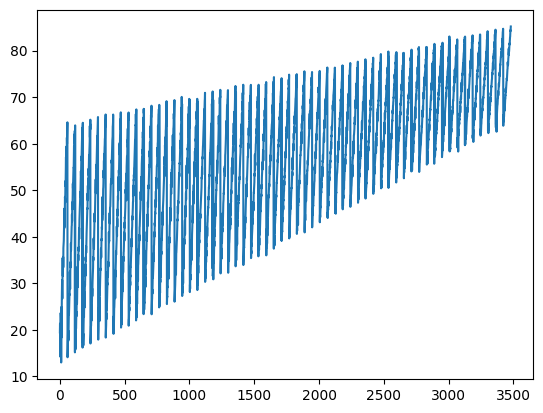

In [6]:
from tqdm import tqdm
import concurrent.futures
from matplotlib import pyplot as plt
farm_population = 100
plot_per_farm = 50
box_per_plot = 50
contamination_rate = 0.06

d_test_rate = 0.03
r_test_rate = 0.04
c_test_rate = 0.05

box_ids_l=[]
box_ids_C_l=[]
dropped_boxes_F_l=[]
dropped_boxes_P_l=[]
dropped_boxes_D_l=[]
dropped_boxes_R_l=[]
dropped_boxes_C_l=[]
detection_percent_l=[]

def run_simulation_wrapper(args):
    f_test_rate, p_test_rate = args
    return run_simulation(farm_population, plot_per_farm, box_per_plot, contamination_rate, f_test_rate, p_test_rate, d_test_rate, r_test_rate, c_test_rate)

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = []
    for f_test_rate in tqdm(np.arange(0.01,0.6,0.01)):
        for p_test_rate in np.arange(0.01,0.6,0.01):
            results.append(executor.submit(run_simulation_wrapper, (f_test_rate, p_test_rate)))

    for future in concurrent.futures.as_completed(results):
        box_ids,box_ids_C, dropped_boxes_F, dropped_boxes_P, dropped_boxes_D, dropped_boxes_R, dropped_boxes_C = future.result()
        box_ids_l.append(len(box_ids))
        box_ids_C_l.append(len(box_ids_C))
        dropped_boxes_F_l.append(len(dropped_boxes_F))
        dropped_boxes_P_l.append(len(dropped_boxes_P))
        dropped_boxes_D_l.append(len(dropped_boxes_D))
        dropped_boxes_R_l.append(len(dropped_boxes_R))
        dropped_boxes_C_l.append(len(dropped_boxes_C))
        detection_percent = ((len(box_ids)-len(box_ids_C))/(contamination_rate*len(box_ids)))*100
        detection_percent_l.append(detection_percent)

plt.plot(detection_percent_l)
plt.show()


In [7]:
# Define functions 

import numpy as np
from tqdm import tqdm
import concurrent.futures
import numba as nb

# generate box id
#@nb.njit(nopython=True)
def generate_box_id(farm_idx, plot_idx, box_idx):
    return farm_idx * 10000000000 + plot_idx * 100000 + box_idx * 10

# generate contaminated box mask
#@nb.njit(parallel=True)
def generate_contamination_mask(total_boxes, contamination_rate):
    contaminated_boxes = int(total_boxes * contamination_rate)
    mask = np.zeros(total_boxes, dtype=np.bool_)
    mask[:contaminated_boxes] = True
    np.random.shuffle(mask)
    return mask

# define testing at each stage
def run_stage(box_ids, contamination_mask, test_rate):
    tested_boxes_mask = np.random.rand(box_ids.shape[0]) < test_rate
    tested_contaminated_boxes = box_ids[np.logical_and(contamination_mask, tested_boxes_mask)]
    if tested_contaminated_boxes.size > 0:
        mask = np.isin(box_ids, tested_contaminated_boxes)
        box_ids_n = box_ids[~mask]
        contamination_mask = contamination_mask[~mask]
        dropped_boxes = set(tested_contaminated_boxes)
    else:
        box_ids_n = box_ids
        dropped_boxes = set()
    remaining_boxes = box_ids_n[~np.isin(box_ids_n, tested_contaminated_boxes)]
    return remaining_boxes, contamination_mask, dropped_boxes

#@nb.njit(parallel=True) 
def isin(a, b):
    out=np.empty(a.shape[0], dtype=nb.boolean)
    b = set(b)
    for i in nb.prange(a.shape[0]):
        if a[i] in b:
            out[i]=True
        else:
            out[i]=False
    return out

# Run simulation
def run_simulation(farm_population, plot_per_farm, box_per_plot, contamination_rate, f_test_rate, p_test_rate,
                   d_test_rate, r_test_rate, c_test_rate):
    total_boxes = farm_population * plot_per_farm * box_per_plot
    box_ids = np.array([generate_box_id(farm_idx, plot_idx, box_idx)
                        for farm_idx in range(1,farm_population+1)
                        for plot_idx in range(1,plot_per_farm+1)
                        for box_idx in range(1,box_per_plot+1)])
    contamination_mask = generate_contamination_mask(total_boxes, contamination_rate)

    box_ids_F, contamination_mask, dropped_boxes_F = run_stage(box_ids, contamination_mask, f_test_rate)
    box_ids_P, contamination_mask, dropped_boxes_P = run_stage(box_ids_F, contamination_mask, p_test_rate)
    box_ids_D, contamination_mask, dropped_boxes_D = run_stage(box_ids_P, contamination_mask, d_test_rate)
    box_ids_R, contamination_mask, dropped_boxes_R = run_stage(box_ids_D, contamination_mask, r_test_rate)
    box_ids_C, contamination_mask, dropped_boxes_C = run_stage(box_ids_R, contamination_mask, c_test_rate)

    return box_ids, box_ids_C, dropped_boxes_F, dropped_boxes_P, dropped_boxes_D, dropped_boxes_R, dropped_boxes_C


100%|██████████| 59/59 [00:00<00:00, 63.81it/s]


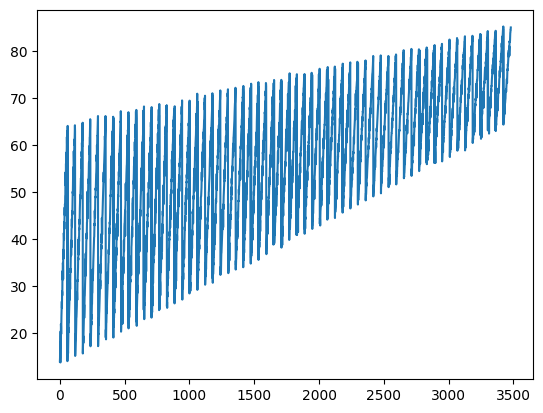

In [8]:
from tqdm import tqdm
import concurrent.futures
from matplotlib import pyplot as plt
farm_population = 100
plot_per_farm = 50
box_per_plot = 50
contamination_rate = 0.06

d_test_rate = 0.03
r_test_rate = 0.04
c_test_rate = 0.05

box_ids_l=[]
box_ids_C_l=[]
dropped_boxes_F_l=[]
dropped_boxes_P_l=[]
dropped_boxes_D_l=[]
dropped_boxes_R_l=[]
dropped_boxes_C_l=[]
detection_percent_l=[]

def run_simulation_wrapper(args):
    f_test_rate, p_test_rate = args
    return run_simulation(farm_population, plot_per_farm, box_per_plot, contamination_rate, f_test_rate, p_test_rate, d_test_rate, r_test_rate, c_test_rate)

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = []
    for f_test_rate in tqdm(np.arange(0.01,0.6,0.01)):
        for p_test_rate in np.arange(0.01,0.6,0.01):
            results.append(executor.submit(run_simulation_wrapper, (f_test_rate, p_test_rate)))

    for future in concurrent.futures.as_completed(results):
        box_ids,box_ids_C, dropped_boxes_F, dropped_boxes_P, dropped_boxes_D, dropped_boxes_R, dropped_boxes_C = future.result()
        box_ids_l.append(len(box_ids))
        box_ids_C_l.append(len(box_ids_C))
        dropped_boxes_F_l.append(len(dropped_boxes_F))
        dropped_boxes_P_l.append(len(dropped_boxes_P))
        dropped_boxes_D_l.append(len(dropped_boxes_D))
        dropped_boxes_R_l.append(len(dropped_boxes_R))
        dropped_boxes_C_l.append(len(dropped_boxes_C))
        detection_percent = ((len(box_ids)-len(box_ids_C))/(contamination_rate*len(box_ids)))*100
        detection_percent_l.append(detection_percent)

plt.plot(detection_percent_l)
plt.show()
